<a href="https://colab.research.google.com/github/BYU-Hydroinformatics/gwbf-notebooks/blob/main/1_GSLB_well_reach_distance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This scripts reads reads the following three sets of input:

1. An **aquifer** file in GEOJSON or shapefile format
2. A CSV file of **well locations**
3. A CSV file of **water level measurements** (time series file)


# 1.Install Packages

In [ ]:
#@markdown ### **Installing packages**
%%capture
!pip install rioxarray
!pip install gstools
!pip install netCDF4
!pip install xlsxwriter

In [ ]:
#@markdown ### **Importing packages**
import calendar
import copy
import datetime
import math
import os
import shutil
import tempfile
import time
import urllib
from pathlib import Path
from timeit import default_timer as timer
from urllib import request
from xml.etree import cElementTree as ET
from datetime import date

import geopandas as gpd
import netCDF4
import gstools as gs
import numpy as np
import pandas as pd
import requests
import xarray
import rioxarray
from scipy import interpolate
from shapely import wkt
from shapely.geometry import mapping
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib
import re
import ipywidgets as widgets
import plotly.express as px
import xlsxwriter

In [ ]:
#@markdown ### **Initializing Summary Logging**
# Initialize summary string to record analysis inputs, parameters, etc
summary = "SUMMARY - Groundwater Level Mapping Analysis\n"
summary += f"Date: {datetime.datetime.now().strftime('%Y-%m-%d')}\n"

# 2.Uploading Aquifer Data

In [ ]:
#@markdown ### **Defining functions for this section**

# looks through columns in dataframe to find matches to use as default for widgets
def find_default_column(possible_names, columns):
    lower_columns = [column.lower() for column in columns]
    for name in possible_names:
        if name.lower() in lower_columns:
            return columns[lower_columns.index(name.lower())]
    return columns[0]

## 2.1 Uploading Aquifer File

In [ ]:
upload_aquifers = files.upload()
aquifers = gpd.GeoDataFrame.from_file(list(upload_aquifers.keys())[0])

aList1 = list(aquifers.columns)

default_a_ID = find_default_column(['AquiferID', 'Aquifer_ID'], aList1)
default_a_name = find_default_column(['Aquifer_Name', "AquiferName", "Name"], aList1)

a_ID = widgets.Dropdown(options=aList1, value=default_a_ID, description = "Aquifer ID")
a_name = widgets.Dropdown(options=aList1, value=default_a_name, description = "Aquifer Name")

a1Items = [a_ID, a_name]
print("\nPlease select the appropriate headers for your file")
widgets.GridBox(a1Items, layout=widgets.Layout(grid_template_columns="repeat(1, 550px)"))

Saving gsl_basin.dbf to gsl_basin.dbf
Saving gsl_basin.prj to gsl_basin.prj
Saving gsl_basin.shp to gsl_basin.shp
Saving gsl_basin.shx to gsl_basin.shx

Please select the appropriate headers for your file


GridBox(children=(Dropdown(description='Aquifer ID', options=('OBJECTID_1', 'OBJECTID_2', 'NAME', 'BASIN', 'sq…

In [ ]:
#@markdown ### **Select the Aquifer you would like to Map**
aList2 = list(aquifers[a_name.value])
aquifer_name = widgets.Dropdown(options=aList2, description = "Aquifer Name")

a2Items = [aquifer_name]
print("\nPlease select the aquifer you would like to map")
widgets.GridBox(a2Items, layout=widgets.Layout(grid_template_columns="repeat(1, 550px)"))


Please select the aquifer you would like to map


GridBox(children=(Dropdown(description='Aquifer Name', options=('GSL Basin',), value='GSL Basin'),), layout=La…

In [ ]:
#@markdown ### **Filter and Display Aquifer Information**
summary += f"aquifer file name: {list(upload_aquifers.keys())[0]}\n"
summary += f"selected aquifer: {aquifer_name.value}\n"
aquifer_index = aquifers[aquifers[a_name.value]==aquifer_name.value].index.values
aquifer = aquifers[aquifers[a_name.value].isin([aquifer_name.value])]
aquifer_ID = list(aquifer[a_ID.value])
aquifer

,OBJECTID_1,OBJECTID_2,NAME,BASIN,sqmi,Acres,AllReports,FullRept99,FullRept10,NonDigital,...,Shape_Leng,Gaz_ID,HUC_6,HU_6_Name,TNMID,Shape_Le_1,Shape_Le_2,Shape_Area,Area_mi2,geometry
0,0,1,GSL Basin,01,787.035296,503705.0,http://water.utah.gov/Landuse/publ.htm,http://water.utah.gov/Landuse/wrlui.pdf,http://water.utah.gov/Landuse/StatewideSummary...,None,...,269759.984642,0,None,None,None,269759.984642,2.811615,0.217221,787.548119,"MULTIPOLYGON (((-114.05234 38.05464, -114.0528..."


## 2.2 Uploading wells file

In [ ]:
upload_wells = files.upload()
wells = pd.read_csv(list(upload_wells.keys())[0])
print(wells.head())
wList = list(wells.columns)
wList.append('NA')

# find defaults for widgets
default_w_ID = find_default_column(['WellID', 'Well_ID'], wList)
default_w_name = find_default_column(['WellName', 'Well_Name'], wList)
default_w_lat = find_default_column(['Latitude', 'Lat', 'lat_dec'], wList)
default_w_long = find_default_column(['Longitude', 'long', 'long_dec'], wList)
default_w_aquifer_ID = find_default_column(['AquiferID', 'Aquifer_ID'], wList)

w_well_ID = widgets.Dropdown(options=wList, value=default_w_ID, description = "Well ID")
w_well_name = widgets.Dropdown(options=wList, value=default_w_name, description = "Well Name")
w_lat = widgets.Dropdown(options=wList, value=default_w_lat, description = "Latitude")
w_long = widgets.Dropdown(options=wList, value=default_w_long, description = "Longitude")
w_aquifer_ID = widgets.Dropdown(options=wList, value=default_w_aquifer_ID, description = "Aquifer ID")

wItems = [w_well_ID, w_well_name, w_lat, w_long, w_aquifer_ID]
print("\nPlease select the appropriate headers for your file")
widgets.GridBox(wItems, layout=widgets.Layout(grid_template_columns="repeat(1, 550px)"))

Saving GSLB_1900-2023_wells_with_aquifers.csv to GSLB_1900-2023_wells_with_aquifers.csv
           Well_ID           Well_Name    lat_dec    long_dec     GSE  \
0  381033113480701   (C-30-18)25aad- 1  38.175796 -113.802750  7098.0   
1  381037113474001   (C-30-17)30bab- 1  38.176306 -113.795500  7193.0   
2  381152113442801   (C-30-17)15cab- 1  38.197833 -113.741167  6550.0   
3  381236113485601   (C-30-18)12cdb- 1  38.210028 -113.815500  7190.0   
4  382113113435401   (C-28-17)22dda- 1  38.353571 -113.732473  5775.0   

   AquiferID Aquifer_Name State  
0          1    GSL Basin    UT  
1          1    GSL Basin    UT  
2          1    GSL Basin    UT  
3          1    GSL Basin    UT  
4          1    GSL Basin    UT  

Please select the appropriate headers for your file


GridBox(children=(Dropdown(description='Well ID', options=('Well_ID', 'Well_Name', 'lat_dec', 'long_dec', 'GSE…

In [ ]:
### **Formatting wells dataframe**
#To avoid type mismatch, convert the aquifer_id found from the aquifer file and the aquiferid column
#in the wells dataframe to both be strings
summary += f"well file name: {list(upload_wells.keys())[0]}\n"
aquifer_ID = [str(item) for item in aquifer_ID]
if (w_aquifer_ID.value !="NA"):
  wells[w_aquifer_ID.value] = wells[w_aquifer_ID.value].astype(str)

wells_gdf = gpd.GeoDataFrame(wells, geometry=gpd.points_from_xy(wells['long_dec'], wells['lat_dec']))
wells_gdf.crs = 'EPSG:4326'
if (w_aquifer_ID.value !="NA"):
  wells_gdf = wells_gdf[wells_gdf[w_aquifer_ID.value].isin(aquifer_ID)]
  print(wells_gdf.head())
wells_gdf.head()

           Well_ID           Well_Name    lat_dec    long_dec     GSE  \
0  381033113480701   (C-30-18)25aad- 1  38.175796 -113.802750  7098.0   
1  381037113474001   (C-30-17)30bab- 1  38.176306 -113.795500  7193.0   
2  381152113442801   (C-30-17)15cab- 1  38.197833 -113.741167  6550.0   
3  381236113485601   (C-30-18)12cdb- 1  38.210028 -113.815500  7190.0   
4  382113113435401   (C-28-17)22dda- 1  38.353571 -113.732473  5775.0   

  AquiferID Aquifer_Name State                     geometry  
0         1    GSL Basin    UT   POINT (-113.80275 38.1758)  
1         1    GSL Basin    UT   POINT (-113.7955 38.17631)  
2         1    GSL Basin    UT  POINT (-113.74117 38.19783)  
3         1    GSL Basin    UT   POINT (-113.8155 38.21003)  
4         1    GSL Basin    UT  POINT (-113.73247 38.35357)  


,Well_ID,Well_Name,lat_dec,long_dec,GSE,AquiferID,Aquifer_Name,State,geometry
0,381033113480701,(C-30-18)25aad- 1,38.175796,-113.802750,7098.0,1,GSL Basin,UT,POINT (-113.80275 38.1758)
1,381037113474001,(C-30-17)30bab- 1,38.176306,-113.795500,7193.0,1,GSL Basin,UT,POINT (-113.7955 38.17631)
2,381152113442801,(C-30-17)15cab- 1,38.197833,-113.741167,6550.0,1,GSL Basin,UT,POINT (-113.74117 38.19783)
3,381236113485601,(C-30-18)12cdb- 1,38.210028,-113.815500,7190.0,1,GSL Basin,UT,POINT (-113.8155 38.21003)
4,382113113435401,(C-28-17)22dda- 1,38.353571,-113.732473,5775.0,1,GSL Basin,UT,POINT (-113.73247 38.35357)


In [ ]:
wells_gdf = wells_gdf[wells_gdf[w_aquifer_ID.value].isin(aquifer_ID)]

In [ ]:
import geopandas as gpd

# Read a shapefile
try:
    gdf = gpd.read_file("gsl_basin.shp")
    print(gdf)  # Print the loaded GeoDataFrame
except Exception as e:
    print(f"Error loading shapefile: {e}")

   OBJECTID_1  OBJECTID_2       NAME BASIN        sqmi     Acres  \
0           0           1  GSL Basin    01  787.035296  503705.0   

                               AllReports  \
0  http://water.utah.gov/Landuse/publ.htm   

                                FullRept99  \
0  http://water.utah.gov/Landuse/wrlui.pdf   

                                          FullRept10 NonDigital  ...  \
0  http://water.utah.gov/Landuse/StatewideSummary...       None  ...   

      Shape_Leng Gaz_ID HUC_6 HU_6_Name  TNMID     Shape_Le_1  Shape_Le_2  \
0  269759.984642      0  None      None   None  269759.984642    2.811615   

  Shape_Area    Area_mi2                                           geometry  
0   0.217221  787.548119  MULTIPOLYGON (((-114.05234 38.05464, -114.0528...  

[1 rows x 41 columns]


<Axes: >

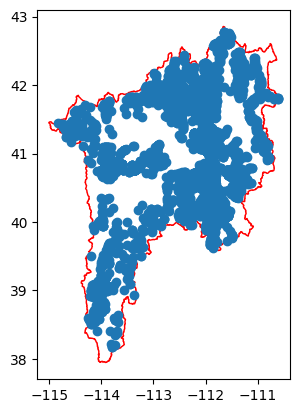

In [ ]:
#@markdown ### **Plotting aquifer and wells**
fig, ax = plt.subplots()
aquifer.plot(color="none", edgecolor="red", ax=ax)
wells_gdf.plot(ax=ax)

In [ ]:
wells_gdf.head()

,Well_ID,Well_Name,lat_dec,long_dec,GSE,AquiferID,Aquifer_Name,State,geometry
0,381033113480701,(C-30-18)25aad- 1,38.175796,-113.802750,7098.0,1,GSL Basin,UT,POINT (-113.80275 38.1758)
1,381037113474001,(C-30-17)30bab- 1,38.176306,-113.795500,7193.0,1,GSL Basin,UT,POINT (-113.7955 38.17631)
2,381152113442801,(C-30-17)15cab- 1,38.197833,-113.741167,6550.0,1,GSL Basin,UT,POINT (-113.74117 38.19783)
3,381236113485601,(C-30-18)12cdb- 1,38.210028,-113.815500,7190.0,1,GSL Basin,UT,POINT (-113.8155 38.21003)
4,382113113435401,(C-28-17)22dda- 1,38.353571,-113.732473,5775.0,1,GSL Basin,UT,POINT (-113.73247 38.35357)


In [ ]:
print(type(wells_gdf))

<class 'geopandas.geodataframe.GeoDataFrame'>


# 3.Upload gages data (gages ID in GSLB)
* the gages in GSLB is from Geoglows team


In [ ]:
# Read gage data from CSV file
gages_df = pd.read_csv('gsl_nwm_gage.csv')



In [ ]:
gages_df.head()

,id,name,River,latitude,longitude,elevation_m,state
0,10011200,WEST FORK BEAR RIVER AT WHITNEY DAM - NR OAKLE...,WEST FORK BEAR RIVER,40.841614,-110.927119,2797,Utah
1,10011500,BEAR RIVER NEAR UTAH-WYOMING STATE LINE,BEAR RIVER,40.965225,-110.853508,2432,Utah
2,10015700,SULPHUR CR.AB.RES.BL.LA CHAPELLE CR.NR EVANSTO...,SULPHUR CREEK,41.129114,-110.806563,2205,Wyoming
3,10015900,SULPHUR CREEK BL RES. - NEAR EVANSTON - WYO.,SULPHUR CREEK,41.156058,-110.835176,2173,Wyoming
4,10016900,BEAR RIVER AT EVANSTON - WY,BEAR RIVER,41.270224,-110.963793,2057,Wyoming


In [ ]:
type(gages_df)

pandas.core.frame.DataFrame

## 3.1 Plot wells and gages

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

def plot_wells_and_gages(wells_gdf, gages_df, aquifer, title="Wells and Gages Locations"):
    """
    Plot wells and gages locations with enhanced visual style

    Parameters:
    wells_gdf: GeoDataFrame containing wells information and geometry
    gages_df: DataFrame containing gages information
    aquifer: GeoDataFrame of aquifer boundary
    title: Title for the plot

    Returns:
    fig, ax: matplotlib figure and axis objects
    """
    # Set the style to 'seaborn-v0_8' to avoid deprecated styles
    plt.style.use('seaborn-v0_8') # Changed line to use seaborn-v0_8

    # Create figure and axis with white background
    fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')
    ax.set_facecolor('#f0f0f0')  # Light gray background

    # Plot aquifer boundary
    aquifer.plot(
        color="#e6f3ff",  # Very light blue fill
        edgecolor="#2171b5",  # Strong blue edge
        linewidth=1.5,
        alpha=0.3,
        ax=ax,
        label="Aquifer Boundary"
    )

    # Convert gages DataFrame to GeoDataFrame
    gages_gdf = gpd.GeoDataFrame(
        gages_df,
        geometry=gpd.points_from_xy(gages_df.longitude, gages_df.latitude)
    )

    # Plot gages first (triangles)
    gages_gdf.plot(
        ax=ax,
        color='#d95f02',  # Orange
        marker='^',
        markersize=80,
        label='Gages',
        alpha=0.8,
        edgecolor='white',
        linewidth=0.5
    )

    # Plot wells
    wells_gdf.plot(
        ax=ax,
        color='#7570b3',  # Purple
        marker='o',
        markersize=40,
        label='Wells',
        alpha=0.8,
        edgecolor='white',
        linewidth=0.5
    )
    # Plot stream
    streams = gpd.read_file("gsl_stream.shp")
    streams.plot(
        ax=ax,
        color='#64b5ed',  # Adjust color to a slightly darker blue
        linewidth=0.5,
        label='Streams',
        zorder=0
    )
    # Customize the plot
    ax.set_title(title, fontsize=14, pad=20, fontweight='bold')

    # Customize legend (Corrected)
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(
        handles, labels,  # Pass handles and labels explicitly
        loc='upper right',
        frameon=True,
        fancybox=True,
        shadow=True,
        framealpha=0.9,
        edgecolor='none',
    )

    # Add subtle gridlines
    ax.grid(True, linestyle='--', alpha=0.3, color='gray')

    # Set equal aspect ratio
    ax.set_aspect('equal')

    # Remove axis labels (if they're not needed)
    # ax.set_xlabel('')
    # ax.set_ylabel('')

    # Add a border to the plot
    for spine in ax.spines.values():
        spine.set_edgecolor('#666666')
        spine.set_linewidth(0.5)

    # Adjust layout
    plt.tight_layout()

    return fig, ax

<ipython-input-27-a642ad9a9c08>:76: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


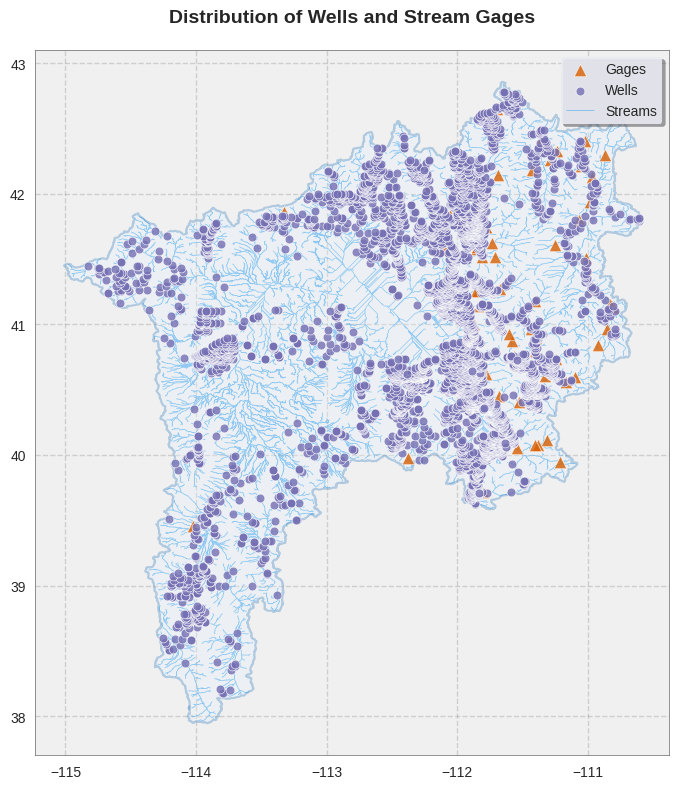

In [ ]:
fig, ax = plot_wells_and_gages(wells_gdf, gages_df, aquifer, title="Distribution of Wells and Stream Gages")
plt.show()

In [ ]:
gages_df.head()

,id,name,River,latitude,longitude,elevation_m,state
0,10011200,WEST FORK BEAR RIVER AT WHITNEY DAM - NR OAKLE...,WEST FORK BEAR RIVER,40.841614,-110.927119,2797,Utah
1,10011500,BEAR RIVER NEAR UTAH-WYOMING STATE LINE,BEAR RIVER,40.965225,-110.853508,2432,Utah
2,10015700,SULPHUR CR.AB.RES.BL.LA CHAPELLE CR.NR EVANSTO...,SULPHUR CREEK,41.129114,-110.806563,2205,Wyoming
3,10015900,SULPHUR CREEK BL RES. - NEAR EVANSTON - WYO.,SULPHUR CREEK,41.156058,-110.835176,2173,Wyoming
4,10016900,BEAR RIVER AT EVANSTON - WY,BEAR RIVER,41.270224,-110.963793,2057,Wyoming
...,...,...,...,...,...,...,...
73,10168500,BIG COTTONWOOD CR NR SALT LAKE CITY UTAH,LITTLE COTTONWOOD CREEK,40.618559,-111.781876,1527,Utah
74,10171000,JORDAN RIVER @ 1700 SOUTH @ SALT LAKE CITY - UT,JORDAN RIVER,40.733557,-111.923270,1294,Utah
75,10172700,VERNON CREEK NEAR VERNON - UT,VERNON CREEK,39.979391,-112.380230,1898,Utah
76,10172860,WARM CREEK NEAR GANDY - UT,WARM CREEK,39.459528,-114.023722,1573,Utah


# Nearest distance to the reach

In [ ]:
import geopandas as gpd

# Read the shapefile
stream_gdf = gpd.read_file("gsl_stream.shp")

In [ ]:
stream_gdf.head()

,fid,LINKNO,DSLINKNO,strmOrder,USContArea,DSContArea,TDXHydroRe,VPUCode,Topologica,LengthGeod,TerminalLi,musk_k,musk_x,geometry
0,21771.0,710738369.0,710740353.0,2.0,60097104.0,61334064.0,7020000010,703.0,214807.0,1116.817679,710930643.0,4467.0,0.25,"LINESTRING (-113.904 38.00756, -113.90411 38.0..."
1,36359.0,710742337.0,710704640.0,3.0,85985648.0,89495320.0,7020000010,703.0,247818.0,1654.902090,710930643.0,6620.0,0.25,"LINESTRING (-113.89644 38.02733, -113.89633 38..."
2,43809.0,710706624.0,710678847.0,3.0,132628064.0,132918688.0,7020000010,703.0,264750.0,716.739736,710930643.0,2867.0,0.25,"LINESTRING (-113.89944 38.036, -113.89956 38.0..."
3,54280.0,710676862.0,710680830.0,3.0,200862624.0,201842960.0,7020000010,703.0,288382.0,709.748489,710930643.0,2839.0,0.25,"LINESTRING (-113.91656 38.06311, -113.91644 38..."
4,51810.0,710682815.0,710684799.0,3.0,182594144.0,182753904.0,7020000010,703.0,282807.0,336.674092,710930643.0,1347.0,0.25,"LINESTRING (-113.91233 38.05078, -113.91222 38..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6712,19974.0,710533928.0,710535912.0,2.0,40824656.0,41430768.0,7020000010,703.0,212007.0,229.206232,710930643.0,917.0,0.25,"LINESTRING (-113.53744 39.75856, -113.53733 39..."
6713,29326.0,710535912.0,710641063.0,2.0,48301832.0,53527024.0,7020000010,703.0,232733.0,2208.638710,710930643.0,8835.0,0.25,"LINESTRING (-113.53878 39.774, -113.53878 39.7..."
6714,19939.0,710337511.0,710690663.0,2.0,11948942.5,23400392.0,7020000010,703.0,211948.0,692.266658,710930643.0,793.0,0.25,"MULTILINESTRING ((-113.38311 39.774, -113.3832..."
6715,19956.0,710686695.0,710688679.0,2.0,29191344.0,33953592.0,7020000010,703.0,211978.0,395.583057,710930643.0,1582.0,0.25,"LINESTRING (-113.37789 39.77067, -113.37778 39..."


In [ ]:
gages_df.head()

,id,name,River,latitude,longitude,elevation_m,state
0,10011200,WEST FORK BEAR RIVER AT WHITNEY DAM - NR OAKLE...,WEST FORK BEAR RIVER,40.841614,-110.927119,2797,Utah
1,10011500,BEAR RIVER NEAR UTAH-WYOMING STATE LINE,BEAR RIVER,40.965225,-110.853508,2432,Utah
2,10015700,SULPHUR CR.AB.RES.BL.LA CHAPELLE CR.NR EVANSTO...,SULPHUR CREEK,41.129114,-110.806563,2205,Wyoming
3,10015900,SULPHUR CREEK BL RES. - NEAR EVANSTON - WYO.,SULPHUR CREEK,41.156058,-110.835176,2173,Wyoming
4,10016900,BEAR RIVER AT EVANSTON - WY,BEAR RIVER,41.270224,-110.963793,2057,Wyoming


In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.ops import nearest_points
from shapely.geometry import Point
from tqdm import tqdm

def extract_reach_centroids(stream_gdf):
    """
    Extract centroids from stream reaches in the required format

    Parameters:
    -----------
    stream_gdf : GeoDataFrame
        Stream network data with geometries

    Returns:
    --------
    DataFrame with reach centroids in decimal degrees
    """
    # Ensure the geometry is in geographic coordinates (WGS84)
    if stream_gdf.crs != "EPSG:4326":
        stream_gdf = stream_gdf.to_crs("EPSG:4326")

    # Extract centroids
    centroids = []
    print("Extracting reach centroids...")
    for reach in tqdm(stream_gdf.itertuples(), total=len(stream_gdf)):
        centroid = reach.geometry.centroid
        centroids.append({
            'Reach_ID': reach.LINKNO,
            'Latitude': centroid.y,
            'Longitude': centroid.x
        })

    # Convert to DataFrame
    centroids_df = pd.DataFrame(centroids)

    # Save centroids to CSV
    output_file = 'reach_centroids.csv'
    centroids_df.to_csv(output_file, index=False)
    print(f"\nCentroids saved to: {output_file}")

    return centroids_df

In [ ]:
centroids_df = extract_reach_centroids(stream_gdf)

Extracting reach centroids...


100%|██████████| 6717/6717 [00:00<00:00, 36555.83it/s]



Centroids saved to: reach_centroids.csv


In [ ]:
centroids_df

,Reach_ID,Latitude,Longitude
0,710738369.0,38.003440,-113.906556
1,710742337.0,38.020757,-113.895623
2,710706624.0,38.033335,-113.900190
3,710676862.0,38.060696,-113.915783
4,710682815.0,38.049483,-113.911622
...,...,...,...
6712,710533928.0,39.757611,-113.537255
6713,710535912.0,39.766185,-113.538314
6714,710337511.0,39.772597,-113.384340
6715,710686695.0,39.769625,-113.376197


In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from tqdm import tqdm

import geopandas as gpd
import pandas as pd
import numpy as np
from tqdm import tqdm

def process_wells_and_reaches(wells_gdf, stream_gdf, gages_df, centroids_elev_df):
    """
    Process wells and stream reaches with correct UTM distance calculations
    """
    # Convert to UTM projection (EPSG:32612 for Utah area)
    print("Converting coordinate systems to UTM...")
    wells_utm = wells_gdf.to_crs("EPSG:32612")
    stream_utm = stream_gdf.to_crs("EPSG:32612")

    print(f"Coordinate systems after conversion:")
    print(f"Wells CRS: {wells_utm.crs}")
    print(f"Streams CRS: {stream_utm.crs}")

    results = []
    total_wells = len(wells_utm)

    print("\nProcessing wells...")
    for well in tqdm(wells_utm.itertuples(), total=total_wells):
        # Calculate distances in meters
        distances = stream_utm.geometry.distance(well.geometry)
        nearest_reach_idx = distances.idxmin()
        nearest_reach = stream_utm.iloc[nearest_reach_idx]
        min_distance = distances.min()

        # Get reach elevation
        reach_elev_data = centroids_elev_df[
            centroids_elev_df['Reach_ID'] == nearest_reach['LINKNO']
        ]

        reach_elevation = reach_elev_data.iloc[0]['Avg_GSE'] if not reach_elev_data.empty else None

        # Find downstream gage
        downstream_gage = find_downstream_gage(
            nearest_reach['LINKNO'],
            stream_gdf,
            gages_df
        )

        # Store results
        results.append({
            'Well_ID': well.Well_ID,
            'Reach_ID': nearest_reach['LINKNO'],
            'Reach_Elevation': reach_elevation,
            'Distance_to_Reach': min_distance,  # Now correctly in meters
            'Downstream_Gage': downstream_gage
        })

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Print summary statistics
    print("\nSummary Statistics:")
    print(f"Total wells processed: {len(results_df)}")
    print(f"Wells with downstream gages: {results_df['Downstream_Gage'].notna().sum()}")
    print(f"Wells with reach elevations: {results_df['Reach_Elevation'].notna().sum()}")
    print("\nDistance statistics (meters):")
    print(f"  Minimum: {results_df['Distance_to_Reach'].min():.2f} m")
    print(f"  Maximum: {results_df['Distance_to_Reach'].max():.2f} m")
    print(f"  Average: {results_df['Distance_to_Reach'].mean():.2f} m")
    print(f"  Median: {results_df['Distance_to_Reach'].median():.2f} m")

    # Calculate distance distribution
    percentiles = [10, 25, 50, 75, 90]
    dist_percentiles = np.percentile(results_df['Distance_to_Reach'], percentiles)
    print("\nDistance percentiles (meters):")
    for p, v in zip(percentiles, dist_percentiles):
        print(f"  {p}th percentile: {v:.2f} m")

    # Save results
    output_file = 'well_reach_relationships_final.csv'
    results_df.to_csv(output_file, index=False)
    print(f"\nResults saved to: {output_file}")

    return results_df

# Keep the existing find_downstream_gage function as is

def find_downstream_gage(reach_id, stream_gdf, gages_df):
    """
    Find downstream gage using network topology
    """
    current_reach = reach_id
    visited_reaches = set()
    path_length = 0

    while current_reach and path_length < 100:  # Limit path length to 100 reaches
        if current_reach in visited_reaches:
            break
        visited_reaches.add(current_reach)

        # Check for gage on current reach
        gage_on_reach = gages_df[gages_df['COMID_v2'] == current_reach]
        if not gage_on_reach.empty:
            return gage_on_reach.iloc[0]['samplingFeatureCode']

        # Move downstream
        reach_row = stream_gdf[stream_gdf['LINKNO'] == current_reach]
        if reach_row.empty:
            break

        downstream_id = reach_row.iloc[0]['DSLINKNO']
        if downstream_id == 0 or pd.isna(downstream_id):
            break

        current_reach = downstream_id
        path_length += 1

    return None



In [ ]:
centroids_elev_df = pd.read_csv('reach_centroids_with_Elev.csv')

# Run analysis
results = process_wells_and_reaches(
    wells_gdf,
    stream_gdf,
    gages_df,
    centroids_elev_df
)


Converting coordinate systems to UTM...
Coordinate systems after conversion:
Wells CRS: EPSG:32612
Streams CRS: EPSG:32612

Processing wells...


100%|██████████| 8752/8752 [12:27<00:00, 11.71it/s]


Summary Statistics:
Total wells processed: 8752
Wells with downstream gages: 4861
Wells with reach elevations: 8752

Distance statistics (meters):
  Minimum: 0.00 m
  Maximum: 5845.15 m
  Average: 727.63 m
  Median: 567.54 m

Distance percentiles (meters):
  10th percentile: 83.51 m
  25th percentile: 238.05 m
  50th percentile: 567.54 m
  75th percentile: 1046.09 m
  90th percentile: 1574.03 m

Results saved to: well_reach_relationships_final.csv


In [ ]:
results.head()

,Well_ID,Reach_ID,Reach_Elevation,Distance_to_Reach,Downstream_Gage
0,381033113480701,710579638.0,2018.0,15.997118,NaN
1,381037113474001,710579638.0,2018.0,387.946514,NaN
2,381152113442801,710579638.0,2018.0,642.085536,NaN
3,381236113485601,710258231.0,2033.5,95.717740,NaN
4,382113113435401,710549872.0,1770.0,375.764745,NaN
